In [10]:
import os
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
base_dir = '/Users/namigabbasov/Desktop/cnn'    ### directory - parent folder 
class_names = ['viral', 'normal', 'covid']      ### subfolder for each class

### obtain file paths and labels using loop
data = []
labels = []

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(base_dir, class_name)
    for file in os.listdir(class_dir):
        if file.endswith(".jpg") or file.endswith(".png"):  
            data.append(os.path.join(class_dir, file))
            labels.append(label)


### convert lists to numpy arrays (helpful for next steps)
data = np.array(data)
labels = np.array(labels)

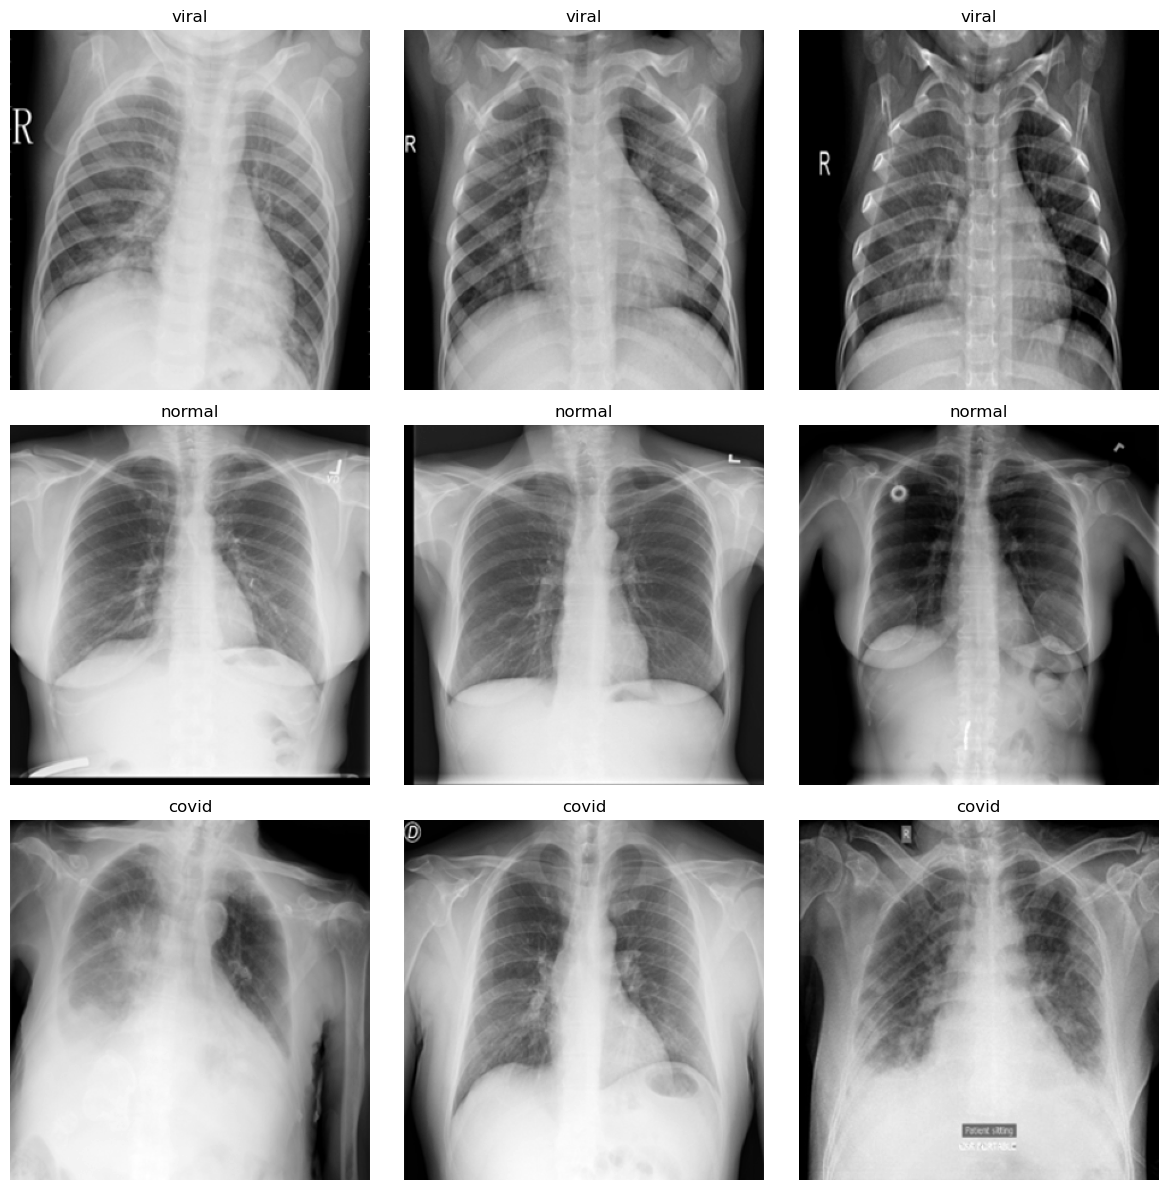

In [12]:
### Function to display images
def display_images(images, titles, rows=1, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    for i, ax in enumerate(axes.flatten()):
        img = Image.open(images[i])
        ax.imshow(img, cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Select some images to display
num_images = 3  ### Number of images to display per class
selected_images = []
titles = []

for class_name in class_names:
    ### path to class directory
    class_dir = os.path.join(base_dir, class_name)
    
    ### get all image files in directory
    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    ### randomly select images
    selected_files = random.sample(all_files, num_images)
    selected_images.extend(selected_files)
    titles.extend([class_name] * num_images)

### Display images
display_images(selected_images, titles, rows=3, cols=3)

In [13]:
### Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
data, labels, test_size=0.2, random_state=42, stratify=labels)   ### use `stratify` for balanced classes

In [14]:
### Function to create directories. 
def create_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Create train and test directories within each class folder

for class_name in class_names:
    create_directory(os.path.join(base_dir, 'train', class_name))
    create_directory(os.path.join(base_dir, 'test', class_name))

In [15]:
import os
from shutil import copyfile

### Function to copy files to appropriate directories
def copy_files(data_set, labels, set_type):
    for filepath, label in zip(data_set, labels):
        file_name = os.path.basename(filepath)
        dest_dir = os.path.join(base_dir, set_type, class_names[label])
        os.makedirs(dest_dir, exist_ok=True)  # Create the destination directory if it doesn't exist
        dest_path = os.path.join(dest_dir, file_name)
        copyfile(filepath, dest_path)

### Copy files(I copied rarther than moving it that I still have samples in original folders)
copy_files(train_data, train_labels, 'train')
copy_files(test_data, test_labels, 'test')

In [16]:
### Initialize training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

### Create the training generator
train_dir = os.path.join(base_dir, 'train')
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Adjust this according to your needs (binary, categorical)
)




### first initialize test data generator
test_datagen = ImageDataGenerator(rescale=1./255)  ### Rescale the image data to [0,1]

### Create the test generator
test_dir = os.path.join(base_dir, 'test')  
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False   ### Shuffle should be False for evaluation to match labels
)

Found 12122 images belonging to 3 classes.
Found 3031 images belonging to 3 classes.


In [17]:
### develop basic CNN model 

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  ### three classes
])

### Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

### Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [18]:
### fit CNN model

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // 32,
    verbose=2
)

Epoch 1/10
378/378 - 92s - loss: 0.6176 - accuracy: 0.7237 - val_loss: 0.3963 - val_accuracy: 0.8152 - 92s/epoch - 244ms/step
Epoch 2/10
378/378 - 89s - loss: 0.4502 - accuracy: 0.8046 - val_loss: 0.2985 - val_accuracy: 0.8790 - 89s/epoch - 237ms/step
Epoch 3/10
378/378 - 91s - loss: 0.3820 - accuracy: 0.8371 - val_loss: 0.2842 - val_accuracy: 0.8803 - 91s/epoch - 241ms/step
Epoch 4/10
378/378 - 94s - loss: 0.3334 - accuracy: 0.8617 - val_loss: 0.2356 - val_accuracy: 0.9016 - 94s/epoch - 248ms/step
Epoch 5/10
378/378 - 92s - loss: 0.3015 - accuracy: 0.8758 - val_loss: 0.2631 - val_accuracy: 0.8920 - 92s/epoch - 244ms/step
Epoch 6/10
378/378 - 93s - loss: 0.2749 - accuracy: 0.8922 - val_loss: 0.1937 - val_accuracy: 0.9255 - 93s/epoch - 245ms/step
Epoch 7/10
378/378 - 93s - loss: 0.2587 - accuracy: 0.8988 - val_loss: 0.1731 - val_accuracy: 0.9342 - 93s/epoch - 246ms/step
Epoch 8/10
378/378 - 90s - loss: 0.2435 - accuracy: 0.9049 - val_loss: 0.1718 - val_accuracy: 0.9372 - 90s/epoch - 237

In [20]:
### Evaluate model on test set

test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

95/95 [==============================] - 8s 87ms/step - loss: 0.1601 - accuracy: 0.9442
Test loss: 0.1600639969110489
Test accuracy: 0.9442428350448608


95/95 [==============================] - 8s 87ms/step


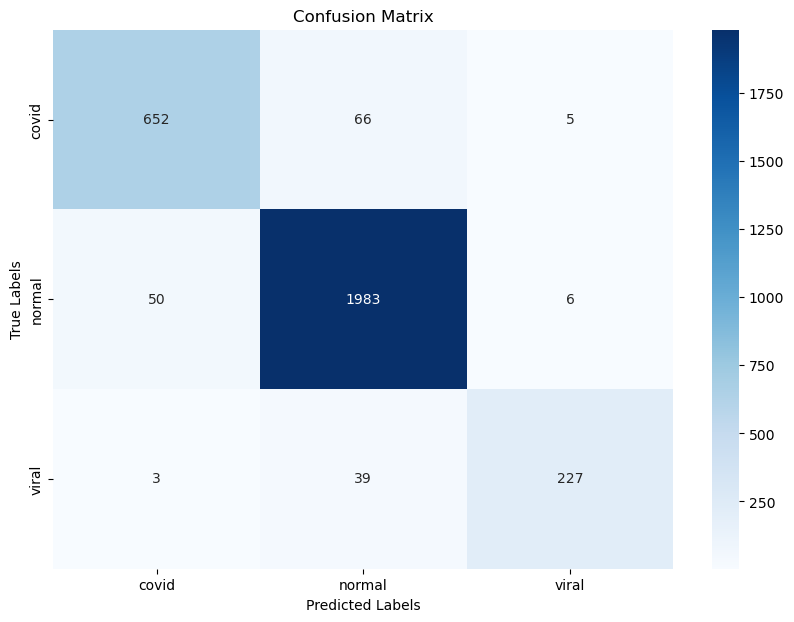

              precision    recall  f1-score   support

       covid       0.92      0.90      0.91       723
      normal       0.95      0.97      0.96      2039
       viral       0.95      0.84      0.90       269

    accuracy                           0.94      3031
   macro avg       0.94      0.91      0.92      3031
weighted avg       0.94      0.94      0.94      3031



In [21]:
### predict labels for test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

### retrieve actual labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  ### Get class labels

### generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

### plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [22]:
### Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

95/95 [==============================] - 9s 90ms/step - loss: 0.1601 - accuracy: 0.9442


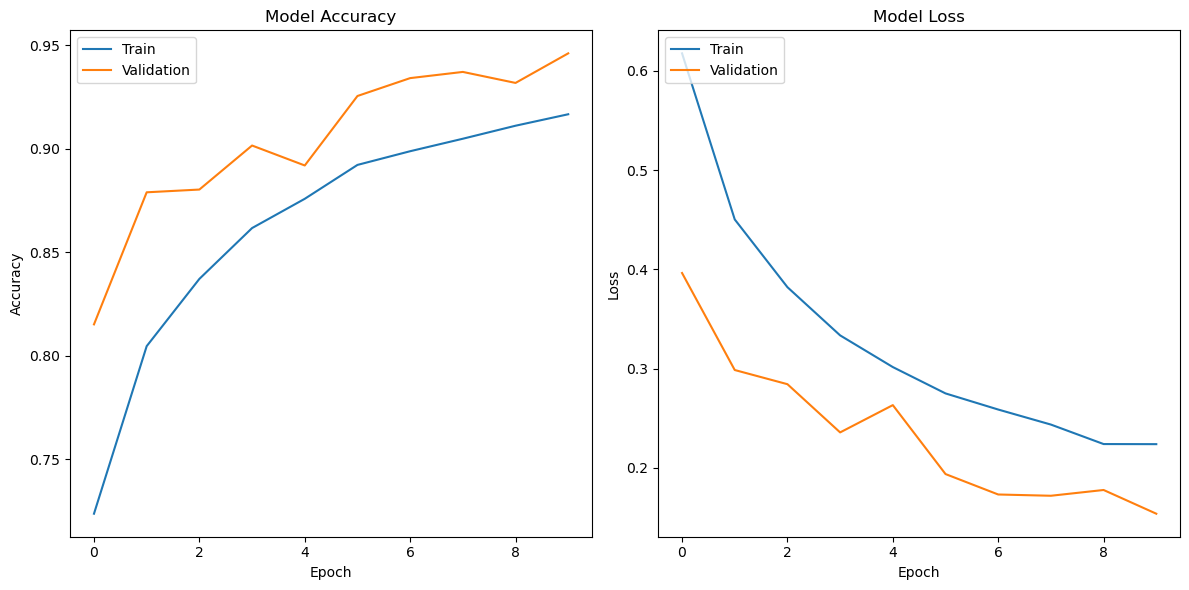

In [23]:
### Summarize history(model) for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot = accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


### Summarize history(model) for loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot = loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()